In [2]:
# machine learning
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight

# geo
from osgeo import gdal
import osr

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# additional
import itertools
import pandas as pd
import datetime as dt
import math
import numpy as np
import random
import time

%matplotlib inline



# define path to classification data
path = f'data/classification_data/'
path_comp = f'data/composites/'
path_coef = f'data/coefficients/'



""" //////////////////////// classes //////////////////////// """

# class to create a deep neural network (dnn). the dnn object is compatible with scikit-learn's
# classifier, i.e. also provides the fit and predict methods.
class DeepNeuralNetwork():
    
    def __init__(self):
        self.trained = False
        self.enc = OneHotEncoder(categories='auto')
        self.model = False
        
        # end of init method
    
    def fit(self, X_train, y_train):
        
        # one hot encoding data
        y_train_onehot = np.asarray(y_train)
        self.enc.fit(y_train_onehot.reshape(-1,1))
        y_train_onehot = self.enc.transform(y_train_onehot.reshape(-1,1)).todense()
        
        # getting input and output dimension of data
        input_dim = len(X_train.columns)
        output_dim = y_train_onehot.shape[1]
        
        # setting up model
        self.model = keras.Sequential([
            keras.layers.Dense(200, input_dim=input_dim, activation=tf.nn.tanh),
            keras.layers.Dense(100, activation=tf.nn.tanh),
            keras.layers.Dense(50, activation=tf.nn.tanh),
            keras.layers.Dense(output_dim, activation=tf.nn.softmax)
        ])
        opt = keras.optimizers.Adam(lr=0.001)
        self.model.compile(
          optimizer=opt,
          loss='categorical_crossentropy',
          metrics = ["accuracy"]
        )
        
        # training deep neural network
        batchsize = 48
        for i in range(6):
            self.model.fit(X_train, y_train_onehot, epochs=20, batch_size=batchsize, verbose=0)#, sample_weight=sample_weights.reshape(-1))
            batchsize *= 2
        
        self.trained = True
        # end of fit method
        

    def predict(self, X_test):
        
        if self.trained:
            y_pred = np.argmax(self.model.predict(X_test), axis=1)
        
        return y_pred
        # end of predict method

        

# class that provides methods to assess classification results by implementing various accuracy metrics.
class ErrorMatrix:

    
    def __init__(self,matrix,labels=False):
        
        self.matrix = matrix
        self.n_classes = matrix.shape[0]

        self.labels = labels if labels else list(range(self.n_classes))
        
        
    def column_total(self):
        
        return list(np.sum(self.matrix, axis=0))
        
    
    def row_total(self):
        
        return list(np.sum(self.matrix, axis=1))
    
    
    def total(self):
        
        return sum(self.column_total())
        
    
    def users_accuracies(self):
    
        row_total = self.row_total()
        uas = [self.matrix[i,i]/float(row_total[i])*100 for i in range(self.n_classes)]
    
        return uas

    
    def average_users_accuracy(self):
        
        return np.mean(self.users_accuracies())
    
    
    def producers_accuracies(self):
    
        column_total = self.column_total()
        pas = [self.matrix[i,i]/float(column_total[i])*100 for i in range(self.n_classes)]
    
        return pas
    
    
    def average_producers_accuracy(self):
        
        return np.mean(self.producers_accuracies())
    
    
    def overall_accuracy(self):
        
        correctly_classified = sum([self.matrix[i,i] for i in range(self.n_classes)])
        total = sum(list(np.sum(self.matrix, axis=1)))
        oa = correctly_classified/float(total)*100
        
        return oa
    
    
    def average_accuracy(self):
    
        aa = np.mean(self.users_accuracies())
    
        return aa

    
    def mean_accuracy(self):
    
        ma = (self.average_accuracy()+self.overall_accuracy())/2.
    
        return ma
    
    
    def kappa(self):
        
        # Cohen's kappa (Cohen, 1960; doi:10.1177/001316446002000104)
        X_test, y_pred = ([],[])
        for index, value in np.ndenumerate(self.matrix):
            pred, label = index
            X_test.extend([label for _ in range(value)])
            y_pred.extend([pred for _ in range(value)])
        
        return cohen_kappa_score(X_test,y_pred)
    
    
    def accuracy_metrics(self):
        
        metrics = {
            'OA': self.overall_accuracy(),
            'AvgUA': self.average_users_accuracy(),
            'AvgPA': self.average_producers_accuracy(),
            'AA': self.average_accuracy(),
            'MA': self.mean_accuracy(),
            'Kappa': self.kappa()
        }

        return metrics
        
        
    def print_matrix(self):
        
        print(self.matrix)
    
    
    def print_summary(self):
        
        print(f'Summary statistics (n Samples: {self.total()})')
        
        print()
        
        # overall statistics        
        print(f'{self.overall_accuracy():.2f} % (OA)')
        print(f'{self.average_users_accuracy():.2f} % (Average UA)')
        print(f'{self.average_producers_accuracy():.2f} % (Average PA)')
        print(f'{self.average_accuracy():.2f} % (AA = Average UA)')
        print(f'{self.mean_accuracy():.2f} % (MA = (OA + AA)/2)')        
        print(f'{self.kappa():.2f} (Kappa)')
        
        print()
        
        # class wise statistics
        column_total = self.column_total()
        row_total = self.row_total()
        
        uas = self.users_accuracies()
        pas = self.producers_accuracies()
        
        for i, label in enumerate(self.labels):
            print(f'{label}: {uas[i]:.2f} % (UA) n Class: {row_total[i]}; {pas[i]:.2f} % (PA) n Ref: {column_total[i]})')
            

    
    def to_latex(self):
        
        return ''

        

""" //////////////////////// functions //////////////////////// """


# function to get arealstatistik data collection year for campaign and roi
def collection_year(roi,yearAS):
    
    if yearAS == 2004:
        if roi=='roi1': return 2007
        if roi=='roi2': return 2006
        if roi=='roi3': return 2004
    if yearAS == 2013:
        if roi=='roi1': return 2016
        if roi=='roi2': return 2015
        if roi=='roi3': return 2013

# function to read in a data cube from a geo tiff file
def geotiff_to_datacube(fname):
    
    ds = gdal.Open(fname)
    
    geotransform = ds.GetGeoTransform()
    
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    epsg = int(proj.GetAttrValue('AUTHORITY',1))
    
    xy_shape = np.array(ds.GetRasterBand(1).ReadAsArray()).shape
    
    # get number of bands in raster file
    n_bands = ds.RasterCount
    
    # initialize a data cube
    xyz_shape = xy_shape + (n_bands,)
    data_cube = np.ndarray(xyz_shape)
    
    # fill it with bands
    for i in range(1,n_bands+1):
        data_cube[:,:,i-1] =  np.array(ds.GetRasterBand(i).ReadAsArray())
    
    return data_cube, geotransform, epsg
    # end of read in datacube function
    
    
def save_geotiff(data_cube,geotransform,epsg,fname):
    
    n_rows, n_cols = data_cube.shape[0:2]
    n_bands = data_cube.shape[2] if len(data_cube.shape)>2 else 1
    
    # open geo tiff file
    ds = gdal.GetDriverByName('GTiff').Create('placeholder.tif',n_cols, n_rows, n_bands, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    ds.SetProjection(srs.ExportToWkt())
    
    # write data cube to geo tiff
    if n_bands==1:
        ds.GetRasterBand(1).WriteArray(data_cube[:,:])
    else:
        for i_band in range(n_bands):
            ds.GetRasterBand(i_band+1).WriteArray(data_cube[:,:,i_band])
    
    dst_ds = gdal.GetDriverByName('GTiff').CreateCopy(fname+'.tif', ds)
    dst_ds = None
    # end of save function
    
    
    # function to plot a classified image  
def plot(image_classified):
     
    # define class labels and colors
    classes = [
        'Artificial areas',
        'Grass and herb vegetation',
        'Brush vegetation', 'Tree vegetation',
        'Bare land', 'Water',
        'Glacier, perpetual snow'
    ]
    
    hex_colors = [
        "#FF0000",
        "#FFFF00",
        "#B2B200",
        "#00B200",
        "#804D33",
        '#0000FF',
        '#B2B2B2'
    ]
    
    cmap = mpl.colors.ListedColormap(hex_colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,7), cmap.N)
        
    # plot map
    fig, ax = plt.subplots(figsize=(10,10))        
    im = ax.imshow(image_classified, cmap=cmap, norm=norm)

    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="5%", pad=0.4, pack_start=False)
    fig.add_axes(cax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=np.linspace(0,7,8))
    cbar.ax.set_yticklabels(classes)
    plt.show()
    # end of plot function
    
      

def train_validate_classifier(clf, train, test, features, label):
        
    # getting training and testing features
    X_train = train[features]
    X_test = test[features]
    
    # getting training and testing labels
    y_train = train[label]
    y_test = test[label]
    
    # training classifier
    start_time = time.time()
    clf.fit(X_train,y_train)
    run_time = time.time() - start_time
    
    # creating error matrix for validation
    y_pred = clf.predict(X_test)
    error_matrix = confusion_matrix(y_test, y_pred)
    
    return ErrorMatrix(error_matrix), run_time, clf






# gaussian filter functions

def apply_gaussian_kernel(data_kernel,gaussian_kernel):
    
    assert(data_kernel.shape==gaussian_kernel.shape)
    
    class_probabilities = {}
    for index, prob in np.ndenumerate(gaussian_kernel):
        class_ = int(data_kernel[index[0],index[1]])
        class_prob = class_probabilities.get(class_,0)
        class_probabilities[class_] = class_prob + prob
    
    new_class = max(class_probabilities, key=class_probabilities.get)
    return new_class




def gaussian_filter(image,kernel_size):
    
    kernel5 = np.array([
        [1,4,7,4,1],
        [4,16,26,16,4],
        [7,26,41,26,7],
        [4,16,26,16,4],
        [1,4,7,4,1]
    ])

    kernel3 = np.array([
        [1,2,1],
        [2,4,2],
        [1,2,1]
    ])
    
    gaussian_kernel = kernel3 if kernel_size==3 else kernel5 
    offset = gaussian_kernel.shape[0]//2

    filtered_image = np.copy(image)
    padded_image = np.pad(image, pad_width=((offset,offset),(offset,offset),(0,0)), mode='edge')
    
    # loop over all pixels ignoring edges
    for i in range(offset,padded_image.shape[0]-offset):
        for j in range(offset,padded_image.shape[1]-offset):
        
            data_kernel = padded_image[i-offset:i+offset+1,j-offset:j+offset+1,0]
            class_filtered = apply_gaussian_kernel(data_kernel,gaussian_kernel)
            filtered_image[i-offset,j-offset,0] = class_filtered
            
    return filtered_image


def validate_filtered(trained_clf,spatial,test,feature_image,label):
    
    y_test, y_pred = ([],[])
    
    for roi in rois:
        
        # subsetting test data to roi
        test_roi = test[test['roi']==roi]
        x_coords = list(test_roi['X'])
        y_coords = list(test_roi['Y'])
        labels = list(test_roi[label])
        
        # getting image data for roi
        year = 2006 if roi=='roi2' else 2007
        image, geotransform, epsg = geotiff_to_datacube(f'{feature_image}_{roi}_{year}.tif')
        xOrigin = geotransform[0]
        yOrigin = geotransform[3]
        pixelWidth = geotransform[1]
        pixelHeight = -geotransform[5]
        
        for i, (x_coord,y_coord,class_) in enumerate(zip(x_coords,y_coords,labels)):
            
            # computing column and row indices
            icol = int((x_coord - xOrigin) / pixelWidth)
            irow = int((yOrigin - y_coord ) / pixelHeight)

            if not spatial:
                
                # create vector of pixels for classifier input
                kernel = image[irow-1:irow+2,icol-1:icol+2,:]
                feature_vector = kernel.reshape((3*3, kernel.shape[2]))
            
            else:
                
                # create vector of kernels for classifier input
                feature_vector = []
                for irowk in range(irow-1,irow+2):
                    for icolk in range(icol-1,icol+2):
                        kernel = image[irowk-1:irowk+2,icolk-1:icolk+2,:]
                        kernel_flattened = kernel.flatten()
                        feature_vector.append(kernel_flattened)
                feature_vector = np.array(feature_vector)
                if i ==0: print(feature_vector.shape)
                                            
            # classify pixel vector and reshape to image
            predictions = trained_clf.predict(feature_vector)
                
            classified_kernel = predictions.reshape((3,3))
        
            class_pred = apply_gaussian_kernel(classified_kernel,gaussian_kernel3)
            
            y_test.append(class_)
            y_pred.append(class_pred)
                
    
    error_matrix = confusion_matrix(y_test, y_pred)
    
    # computing average user's and producer's accuracy
    avg_uacc = compute_avg_uacc(error_matrix)
    avg_pacc = compute_avg_pacc(error_matrix)
    
    return (avg_uacc, avg_pacc)




In [9]:
data_coefs = pd.read_csv(f'{path}coefficients_labeled_as{yearAS}.csv')
data_coefs.head()

,roi,X,Y,land_cover,topleft_blue_c,topleft_blue_a1,topleft_blue_b1,topleft_green_c,topleft_green_a1,topleft_green_b1,...,lowerright_red_b1,lowerright_nir_c,lowerright_nir_a1,lowerright_nir_b1,lowerright_swir1_c,lowerright_swir1_a1,lowerright_swir1_b1,lowerright_swir2_c,lowerright_swir2_a1,lowerright_swir2_b1
0,roi1,667600,237700,1,430.247589,-4.346140,-41.496170,806.920349,-58.442146,-95.429054,...,-144.079315,3831.171631,-238.796066,300.937561,2144.223877,-317.795502,-286.415436,1144.639282,-242.170456,-224.482101
1,roi1,667600,237800,3,328.148468,34.003731,31.237612,535.412781,5.096352,59.066689,...,29.213007,3188.469238,-793.665527,24.569077,2005.135620,-49.025146,-1.157635,1041.241089,59.999222,62.952778
2,roi1,667600,237900,3,267.022400,-23.944775,30.421154,422.210815,-88.935143,46.191063,...,38.235607,2311.928223,-746.261353,-115.506622,1073.557251,-265.009918,-11.981676,521.891296,-103.090691,28.802828
3,roi1,667600,238000,3,316.303864,36.062489,-28.380636,487.278351,4.214088,-6.462491,...,27.055147,1931.999634,-752.164856,-7.233705,929.202698,-305.876678,27.012833,508.900452,-85.097084,12.034341
4,roi1,667600,238100,3,285.278870,-24.541515,26.182205,505.166382,-82.867439,41.132927,...,63.541565,2083.994385,-968.598083,-13.699615,1102.187500,-364.497284,28.245539,563.091187,-112.110519,40.016853


In [10]:
data_acomp = pd.read_csv(f'{path}annual_composite_labeled_as{yearAS}.csv')
data_acomp.head()

,roi,X,Y,land_cover,blue,green,red,nir,swir1,swir2
0,roi1,667600,237700,1,320.0,562.0,448.0,2998.0,1358.0,589.0
1,roi1,667600,237800,3,307.0,456.0,326.0,1942.0,1260.0,554.0
2,roi1,667600,237900,3,211.0,335.0,206.0,1485.0,648.0,276.0
3,roi1,667600,238000,3,222.0,320.0,202.0,1317.0,437.0,240.0
4,roi1,667600,238100,3,208.0,336.0,205.0,1551.0,701.0,309.0


In [11]:
data_scomp = pd.read_csv(f'{path}seasonal_composite_labeled_as{yearAS}.csv')
data_scomp.head()

,roi,X,Y,land_cover,blue_spring,blue_summer,blue_autumn,green_spring,green_summer,green_autumn,...,red_autumn,nir_spring,nir_summer,nir_autumn,swir1_spring,swir1_summer,swir1_autumn,swir2_spring,swir2_summer,swir2_autumn
0,roi1,667600,237700,1,339.0,307.0,308.0,589.0,561.0,638.0,...,361.0,2930.0,2930.0,2761.0,1334.0,1358.0,1426.0,549.0,589.0,552.0
1,roi1,667600,237800,3,264.0,251.0,224.0,422.0,457.0,373.0,...,263.0,1848.0,1848.0,1812.0,1258.0,1261.0,1242.0,612.0,554.0,507.0
2,roi1,667600,237900,3,230.0,203.0,199.0,315.0,310.0,292.0,...,205.0,1456.0,1456.0,1354.0,542.0,542.0,536.0,240.0,240.0,232.0
3,roi1,667600,238000,3,238.0,221.0,229.0,283.0,316.0,279.0,...,200.0,1039.0,1039.0,998.0,403.0,437.0,382.0,213.0,199.0,196.0
4,roi1,667600,238100,3,215.0,208.0,199.0,339.0,336.0,308.0,...,198.0,1447.0,1447.0,1322.0,702.0,702.0,677.0,332.0,309.0,277.0


In [5]:
rois = ['roi1','roi2','roi3']

label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
seasons = ['spring','summer','autumn']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']

features_ac = bands
features_sc = [f'{band}_{season}' for band in bands for season in seasons]
features_t = [f'midcenter_{band}_{coef}' for band in bands for coef in coefficients]
features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]

# split between training and testing data
test_size = 0.3

# define filter used for gaussian filtering
gaussian_kernel3 = np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
])

# define classifiers
classifiers = {}
classifiers['rf'] = RandomForestClassifier(n_estimators=100,class_weight='balanced')
classifiers['svm'] = svm.SVC(gamma='scale', decision_function_shape='ovo', class_weight='balanced')
classifiers['dnn'] = DeepNeuralNetwork()



# data container and function to add data to it
data = []


# define number of iterations
n_iterations = 3

for i in range(n_iterations):
    print(f'Iteration: {i+1}/{n_iterations}')
    
    # splitting data (using a different split for each iteration)
    train_acomp, test_acomp = train_test_split(data_acomp, test_size=test_size)
    # train_scomp, test_scomp = train_test_split(data_scomp, test_size=test_size)
    train_coefs, test_coefs = train_test_split(data_coefs, test_size=test_size)
        
    for clf_key in classifiers.keys():
        print(clf_key,end=' ')
        
        clf  = classifiers[clf_key]
        
        # ac (annual composite)
        error_matrix_ac, run_time_ac, _ = train_validate_classifier(clf,train_acomp,test_acomp,features_ac,label)
        ametrics_ac = error_matrix_ac.accuracy_metrics()
        data.append((clf_key,'ac',test_size,run_time_ac,ametrics_ac))
        
        # sc (seasonal composite)
        # error_matrix_sc, run_time_sc, _ = train_validate_classifier(clf,train_scomp,test_scomp,features_sc,label)
        # ametrics_sc = ErrorMatrix(error_matrix_sc).accuracy_metrics()
        # data.append((clf_key,'sc',test_size,run_time_sc,ametrics_sc))
        
        # t (time series)
        error_matrix_t, run_time_t, _ = train_validate_classifier(clf,train_coefs,test_coefs,features_t,label)
        ametrics_t = error_matrix_t.accuracy_metrics()
        data.append((clf_key,'t',test_size,run_time_t,ametrics_t))
        
        # ts (time series-spatial)
        error_matrix_ts, run_time_ts, _ = train_validate_classifier(clf,train_coefs,test_coefs,features_ts,label)
        ametrics_ts = error_matrix_ts.accuracy_metrics()
        data.append((clf_key,'ts',test_size,run_time_ts,ametrics_ts))
        
    print('')
    
d = {
    'classifier': [entry[0] for entry in data],
    'method': [entry[1] for entry in data],
    'testsize': [f'{entry[2]:.2f}' for entry in data],
    'runtime': [entry[3] for entry in data],
    'OA': [entry[4]['OA'] for entry in data],
    'AvgUA': [entry[4]['AvgUA'] for entry in data],
    'AvgPA': [entry[4]['AvgPA'] for entry in data],
    'AA': [entry[4]['AA'] for entry in data],
    'MA': [entry[4]['MA'] for entry in data],
    'Kappa': [entry[4]['Kappa'] for entry in data],
}
df = pd.DataFrame(data=d)
df.to_csv(f'{path}classifier_comparison_as{yearAS}.csv', encoding='utf-8', index=False)
df.head()

Iteration: 1/3
rf 

KeyboardInterrupt: 

In [ ]:
# plotting the classifier comparison

# chose 2 accuracy metrics
am_x = 'AvgUA'
am_y = 'AvgPA'


df = pd.read_csv(f'data/classification_data/classifier_comparison_as{yearAS}.csv')
df = df.dropna()

grouped = df.groupby(['method','classifier'])
print(df.groupby(['classifier','method'])[('OA','AA','MA','Kappa')].mean())
print(df.groupby(['classifier','method'])[('OA','AA','MA','Kappa')].std())
means = grouped.mean().to_dict()
stds = grouped.std().to_dict()


fig, axes = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(14)
plt.subplots_adjust(wspace=0.25)
axes = axes.ravel()

ax = axes[0]
fontsize = 12
plt.rcParams.update({'font.size': fontsize})


classifiers = ['rf','svm','dnn']
markers = ['o','^','*']


methods = ['ac','t','ts']
inputs = ['Composite', 'Time series', 'Time series-spatial']
colors = ['#377eb8','#4daf4a','#984ea3']

# classifiers (shape) for legend
cpoints = []
for i, clf in enumerate(classifiers):
    cpoint = ax.scatter(
        means[am_x][('ac',clf)],
        means[am_y][('ac',clf)],
        marker=markers[i],
        color='k',
        label=clf,
        s=1,
    )
    cpoints.append(cpoint)
    
# methods (color) for legend
mpoints = []
for i, method in enumerate(methods):
    mpoint = ax.scatter(
        means[am_x][(method,'rf')],
        means[am_y][(method,'rf')],
        marker='s',
        color=colors[i],
        label=inputs[i],
        s=1,
    )
    mpoints.append(mpoint)

# print accuracy data for classifiers and methods
for iclf, clf in enumerate(classifiers):
    for im, m in enumerate(methods):
        key = (m,clf)
        ax.errorbar(
            x=means[am_x][key],
            xerr=stds[am_x][key],
            y=means[am_y][key],
            yerr=stds[am_y][key],
            ms=8,
            c=colors[im],
            marker=markers[iclf],
            ecolor='k',
            elinewidth=1,
        )


lower, upper = (50,90)
limits = [lower,upper]
ticks = np.arange(lower,upper+1,10)
labels = [f'{tick:.0f}' for tick in list(ticks)]

ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)
ax.set_xticklabels(labels)

ax.set_xlabel('Average user\'s accuracy (%)')
ax.set_ylabel('Average producer\'s accuracy (%)')

legend_xpos = 2.68

leg1 = ax.legend(
    cpoints,
    [clf.upper() for clf in classifiers],
    title='Classifier',
    bbox_to_anchor=(legend_xpos, 0.9),
    frameon=False,
    markerscale=8,
    handletextpad=1,
)
leg1._legend_box.align = "left"

leg2 = ax.legend(
    mpoints,
    inputs,
    title='Method',
    loc='center',
    bbox_to_anchor=(legend_xpos, 0.27),
    frameon=False,
    markerscale=8,
    handletextpad=1,
)
leg2._legend_box.align = "left"
ax.add_artist(leg1)



# change axis to right axis for runtime plot
ax = axes[1]


mean_runtime_data = []
std_runtime_data = []

for m in methods:
    runtime_mean_method = [means['runtime'].get((m,clf)) for clf in classifiers]
    mean_runtime_data.append(runtime_mean_method)
    runtime_std_method = [stds['runtime'].get((m,clf)) for clf in classifiers]
    std_runtime_data.append(runtime_std_method)


for i, (mean, std) in enumerate(zip(mean_runtime_data,std_runtime_data)):
    
    # rescaling to minutes
    mean = [m/60. for m in mean]
    std = [s/60. for s in std]
   
    
    wbar = 0.2
    xpos = [x-wbar+i*wbar for x in range(len(classifiers))]
     
    ax.bar(
        x=xpos,
        height=mean,
        yerr=std,
        width=0.2,
        color=colors[i],
        error_kw={'ecolor':'k','elinewidth':1},
    )
    

    
yticks = np.arange(0,21,5)
yticklabels = [f'{ytick:.0f}' for ytick in list(yticks)]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)


# ax.set_ylabel('Runtime (min)',rotation=270,labelpad=20)
ax.set_ylabel('Runtime (min)')
ax.set_xticks(range(3))
ax.set_xticklabels([clf.upper() for clf in classifiers])
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")

axes[2].axis('off')

plt.savefig('plots/classifier_comparison',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
rois = ['roi1','roi2','roi3']

label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']

features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]

subsample_sizes = [1,10,100,1000]
test_size = 0.3

# define classifiers
classifiers = {}
classifiers['rf'] = RandomForestClassifier(n_estimators=100,class_weight='balanced')
# classifiers['svm'] = svm.SVC(gamma='scale', decision_function_shape='ovo', class_weight='balanced')
# classifiers['dnn'] = DeepNeuralNetwork()


# data container
data = []
def add_data(data,base,users,producers):
    for i, (u,p) in enumerate(zip(users,producers)):
        data.append((i,*base,u,p))

# define number of iterations
n_iterations = 30

for i in range(n_iterations):
    print(f'Iteration: {i+1}/{n_iterations}')
    
    for s in subsample_sizes:
        
        
        # splitting data (using a different split and split ratio for each iteration)        
        train_coefs, test_coefs = train_test_split(data_coefs, test_size=test_size)
        trainsubsample_coefs = [train_coefs[train_coefs['land_cover']==i].sample(n=s) for i in range(7)]
        trainsubsample_coefs = pd.concat(trainsubsample_coefs)
        
        
        for clf_key in classifiers.keys():
            print(f'{clf_key} {s}')
            clf  = classifiers[clf_key]
            
            # ts (time series-spatial)
            error_matrix_ts, run_time_ts, _ = train_validate_classifier(clf,trainsubsample_coefs,test_coefs,features_ts,label)
            users_ts = error_matrix_ts.users_accuracies()
            producers_ts = error_matrix_ts.producers_accuracies()
            add_data(data,(clf_key,'ts',s,run_time_ts),users_ts,producers_ts)
            
            
                        
d = {
    'land_cover': [entry[0] for entry in data],
    'classifier': [entry[1] for entry in data],
    'method': [entry[2] for entry in data],
    'ntraining': [entry[3] for entry in data],
    'runtime': [entry[4] for entry in data],
    'UA': [entry[5] for entry in data],
    'PA': [entry[6] for entry in data],
}
       
df = pd.DataFrame(data=d)
df.to_csv(f'{path}training_size_as{yearAS}.csv', encoding='utf-8', index=False)
df.head()


In [ ]:
df = pd.read_csv(f'{path}training_size_as{yearAS}.csv')



metrics = ['UA','PA']
classifier = 'rf'
method = 'ts'
subsample_sizes = [1,10,100,1000]
print(subsample_sizes)

classes = ['Artificial areas', 'Grass and herb vegetation', 'Brush vegetation', 'Tree vegetation', 'Bare land', 'Watery areas', 'Glacier, perpetual snow']
hex_colors = ["#FF0000","#FFFF00","#B2B200","#00B200","#804D33",'#0000FF','#B2B2B2']


fig, axes = plt.subplots(1,2,sharey=True)
fig.set_figheight(4)
fig.set_figwidth(12)
plt.subplots_adjust(wspace=0.15)
plt.xscale(value='log')
axes = axes.ravel()

fontsize = 16
plt.rcParams.update({'font.size': fontsize})

df = df[(df['method']==method) & (df['classifier']==classifier)]


    
for j, (class_,color) in enumerate(zip(classes,hex_colors)):
    df_class = df[df['land_cover']==j]
    means = df_class.groupby(['ntraining']).mean()
    y_uas = list(means['UA'])
    y_pas = list(means['PA'])
    
    axes[0].plot(subsample_sizes,y_uas,color=color,label=class_)
    axes[1].plot(subsample_sizes,y_pas,color=color,label=class_)
    

ymin, ymax = (0,100)
yticks = list(range(ymin,ymax+1,20))
xmin, xmax = (1,1000)

for ax in axes:
    ax.set_xscale('log')
    ax.minorticks_off()
    ax.set_ylim([ymin,ymax])
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks,fontdict={'fontsize': fontsize})
    
    ax.set_xlim([subsample_sizes[0],subsample_sizes[-1]])
    ax.set_xticks(subsample_sizes)
    ax.set_xticklabels(subsample_sizes,fontdict={'fontsize': fontsize})
    
    ax.set_xlabel('n Samples',fontsize=fontsize,fontweight='normal')
    
    



    
axes[0].set_ylabel('Accuracy (%)',fontsize=fontsize,fontweight='normal')
# axes[1].set_ylabel('Producer\'s accuracy (%)',fontsize=fontsize,fontweight='bold')
axes[1].set_xlabel('n Samples')

axes[0].set_title('User\'s',fontsize=fontsize,fontweight='bold')
axes[1].set_title('Producer\'s',fontsize=fontsize,fontweight='bold')

plt.savefig('plots/trainingsample_size',dpi=300,bbox_inches='tight')
plt.show()


Annual composite
[[3234  502   25  224  109   15    0]
 [ 349 7190   16 1231  535    6    0]
 [  88  517   75  611  106    2    0]
 [ 205 1164   30 7428  157   17    0]
 [ 130  748   10  354 4402    6   29]
 [  37   38    0   48   29 1044    0]
 [   0    0    0    0   72    0  267]]
Summary statistics (n Samples: 31050)

76.14 % (OA)
69.61 % (Average UA)
77.32 % (Average PA)
69.61 % (AA = Average UA)
72.87 % (MA = (OA + AA)/2)
0.69 (Kappa)

0: 78.71 % (UA) n Class: 4109; 79.99 % (PA) n Ref: 4043)
1: 77.09 % (UA) n Class: 9327; 70.77 % (PA) n Ref: 10159)
2: 5.36 % (UA) n Class: 1399; 48.08 % (PA) n Ref: 156)
3: 82.52 % (UA) n Class: 9001; 75.06 % (PA) n Ref: 9896)
4: 77.51 % (UA) n Class: 5679; 81.37 % (PA) n Ref: 5410)
5: 87.29 % (UA) n Class: 1196; 95.78 % (PA) n Ref: 1090)
6: 78.76 % (UA) n Class: 339; 90.20 % (PA) n Ref: 296)


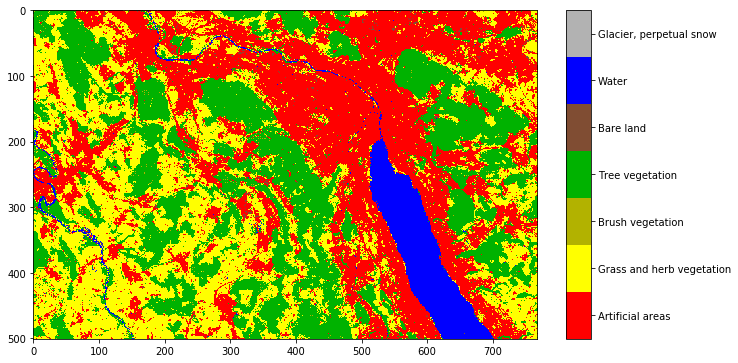

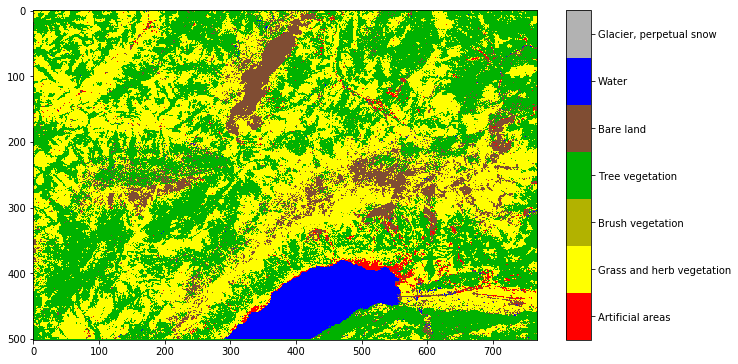

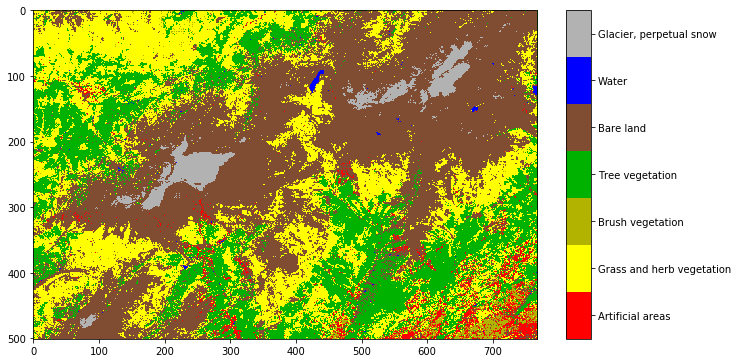

Seasonal composite
[[3277  545   26  203   81    9    0]
 [ 351 7510   24 1185  539    3    0]
 [  82  502   77  564   92    0    0]
 [ 238 1165   18 7297  149   12    0]
 [ 112  647   11  319 4475    2   23]
 [  46   41    0   47   36 1037    0]
 [   0    0    0    0   81    0  224]]
Summary statistics (n Samples: 31050)

76.96 % (OA)
69.25 % (Average UA)
78.22 % (Average PA)
69.25 % (AA = Average UA)
73.10 % (MA = (OA + AA)/2)
0.70 (Kappa)

0: 79.14 % (UA) n Class: 4141; 79.81 % (PA) n Ref: 4106)
1: 78.13 % (UA) n Class: 9612; 72.14 % (PA) n Ref: 10410)
2: 5.85 % (UA) n Class: 1317; 49.36 % (PA) n Ref: 156)
3: 82.18 % (UA) n Class: 8879; 75.89 % (PA) n Ref: 9615)
4: 80.07 % (UA) n Class: 5589; 82.06 % (PA) n Ref: 5453)
5: 85.92 % (UA) n Class: 1207; 97.55 % (PA) n Ref: 1063)
6: 73.44 % (UA) n Class: 305; 90.69 % (PA) n Ref: 247)


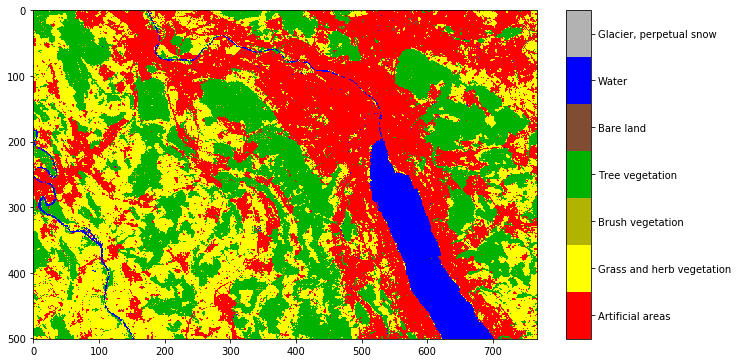

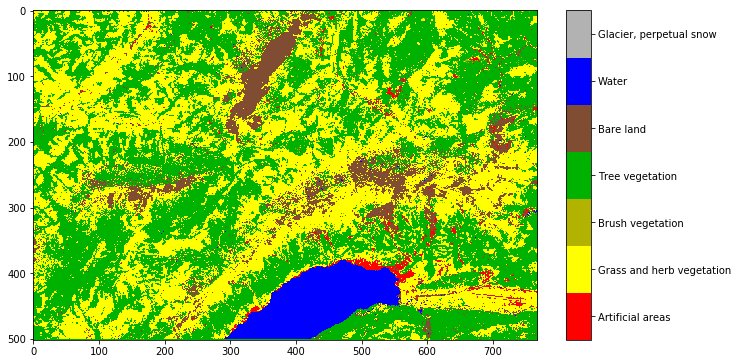

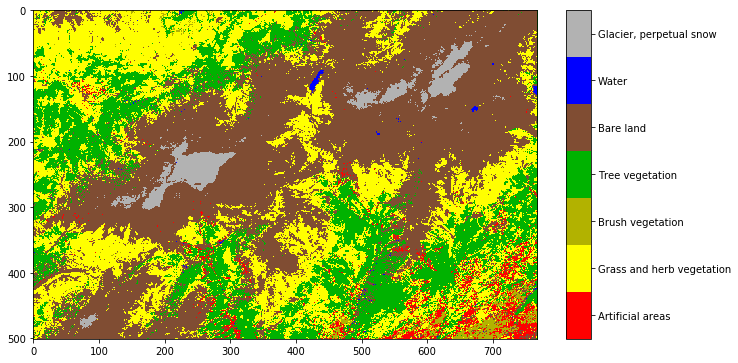

Time series
[[3279  556   17  189   50   14    0]
 [ 317 7825   23 1013  362    4    0]
 [  50  550  145  551   92    0    0]
 [ 157 1014   29 7469  105    9    0]
 [  91  598   18  203 4713    3   63]
 [  22   23    0   68   27 1032    0]
 [   0    0    0    0  109    2  258]]
Summary statistics (n Samples: 31050)

79.62 % (OA)
71.17 % (Average UA)
80.38 % (Average PA)
71.17 % (AA = Average UA)
75.39 % (MA = (OA + AA)/2)
0.73 (Kappa)

0: 79.88 % (UA) n Class: 4105; 83.73 % (PA) n Ref: 3916)
1: 81.99 % (UA) n Class: 9544; 74.06 % (PA) n Ref: 10566)
2: 10.45 % (UA) n Class: 1388; 62.50 % (PA) n Ref: 232)
3: 85.04 % (UA) n Class: 8783; 78.68 % (PA) n Ref: 9493)
4: 82.84 % (UA) n Class: 5689; 86.35 % (PA) n Ref: 5458)
5: 88.05 % (UA) n Class: 1172; 96.99 % (PA) n Ref: 1064)
6: 69.92 % (UA) n Class: 369; 80.37 % (PA) n Ref: 321)


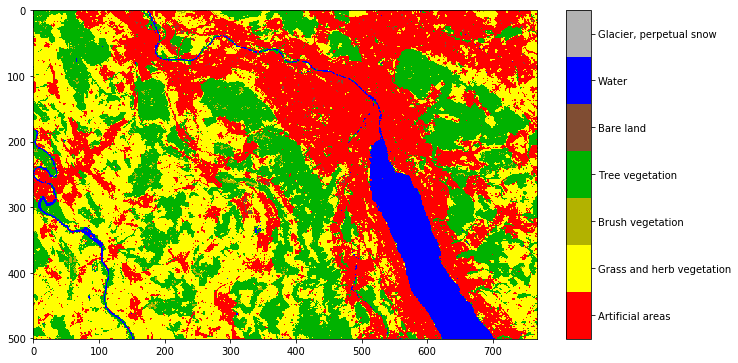

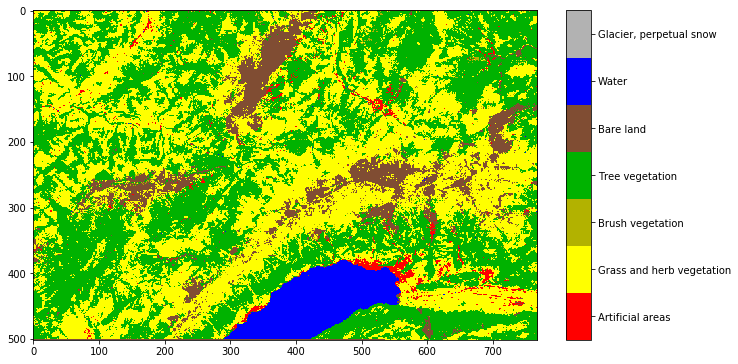

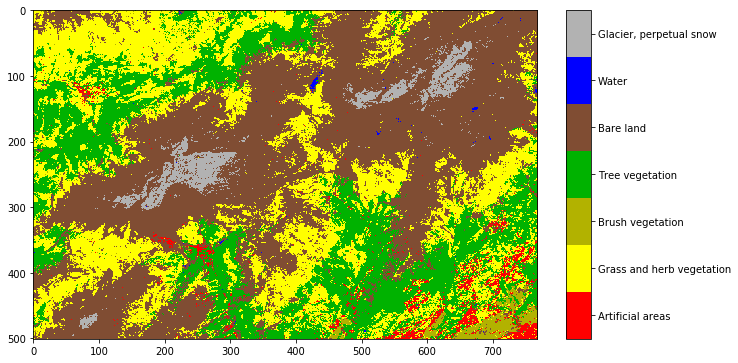

Time series-spatial
[[3318  551   14  170   36   16    0]
 [ 270 8065   11  859  336    3    0]
 [  41  550  145  569   83    0    0]
 [ 126  974   26 7562   89    6    0]
 [  63  620    7  213 4755    1   30]
 [  24   24    0   61   30 1033    0]
 [   0    0    0    0   94    0  275]]
Summary statistics (n Samples: 31050)

81.01 % (OA)
72.59 % (Average UA)
84.02 % (Average PA)
72.59 % (AA = Average UA)
76.80 % (MA = (OA + AA)/2)
0.75 (Kappa)

0: 80.83 % (UA) n Class: 4105; 86.36 % (PA) n Ref: 3842)
1: 84.50 % (UA) n Class: 9544; 74.79 % (PA) n Ref: 10784)
2: 10.45 % (UA) n Class: 1388; 71.43 % (PA) n Ref: 203)
3: 86.10 % (UA) n Class: 8783; 80.16 % (PA) n Ref: 9434)
4: 83.58 % (UA) n Class: 5689; 87.68 % (PA) n Ref: 5423)
5: 88.14 % (UA) n Class: 1172; 97.54 % (PA) n Ref: 1059)
6: 74.53 % (UA) n Class: 369; 90.16 % (PA) n Ref: 305)


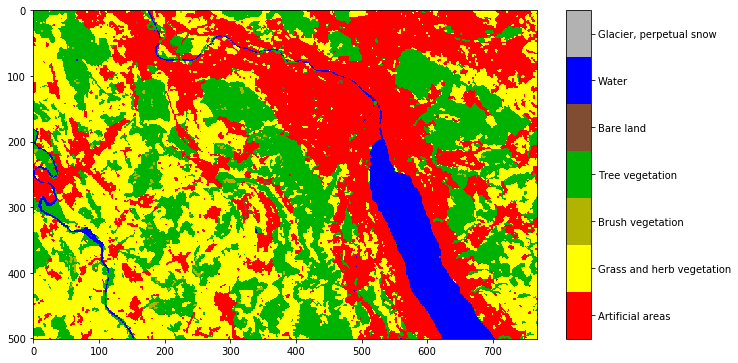

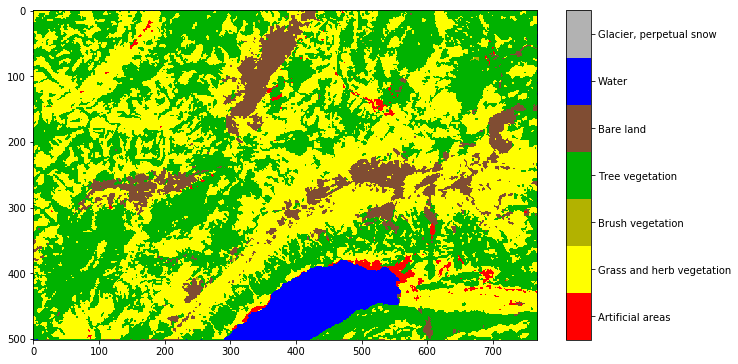

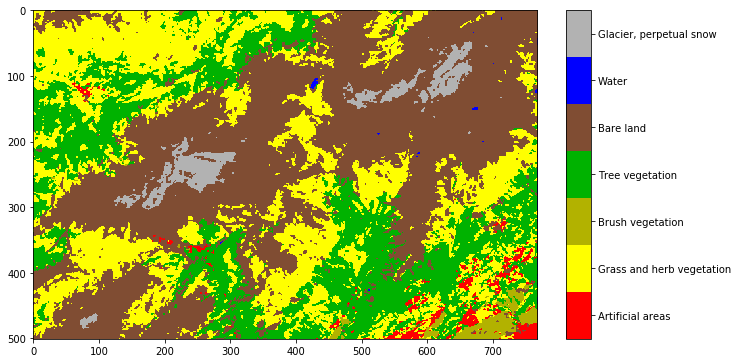

In [13]:
# best working approach confusion matrix (class-wise) analysis and visual analysis

rois = ['roi1','roi2','roi3']


label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']
seasons = ['spring','summer','autumn']

features_ac = bands
features_sc = [f'{band}_{season}' for band in bands for season in seasons]
features_t = [f'midcenter_{band}_{coef}' for band in bands for coef in coefficients]
features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]

# split between training and testing data
test_size = 0.3

train_acomp, test_acomp = train_test_split(data_acomp, test_size=test_size)
train_scomp, test_scomp = train_test_split(data_scomp, test_size=test_size)
train_coefs, test_coefs = train_test_split(data_coefs, test_size=test_size)

# define filter used for gaussian filtering
gaussian_kernel3 = np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
])

# define best working classifiers
clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')


print('Annual composite')      
error_matrix_ac, _, trained_clf = train_validate_classifier(clf,train_acomp,test_acomp,features_ac,label)
error_matrix_ac.print_matrix()
error_matrix_ac.print_summary()

for roi in rois:
    fname = f'{path_comp}annual_composite_{roi}_{collection_year(roi,yearAS)}.tif'
    composite, geotransform, epsg = geotiff_to_datacube(fname)
    # convert image to vector of pixels
    shape = composite.shape
    pixel_vector = composite.reshape((shape[0]*shape[1], shape[2]))
    
    # classify pixel vector and reshape to image
    predictions = trained_clf.predict(pixel_vector)
    composite_classified = predictions.reshape((shape[0],shape[1]))
    
    save_geotiff(composite_classified,geotransform,epsg,f'{path}rf_ac_{roi}_as{yearAS}')
    plot(composite_classified)

    
print('Seasonal composite')      
error_matrix_sc, _, trained_clf = train_validate_classifier(clf,train_scomp,test_scomp,features_sc,label)
error_matrix_sc.print_matrix()
error_matrix_sc.print_summary()

for roi in rois:
    
    fname_spring = f'{path_comp}seasonal_composite_spring_{roi}_{collection_year(roi,yearAS)}.tif'
    comp_spring, geotransform, epsg = geotiff_to_datacube(fname_spring)
    
    fname_summer = f'{path_comp}seasonal_composite_summer_{roi}_{collection_year(roi,yearAS)}.tif'
    comp_summer, geotransform, epsg = geotiff_to_datacube(fname_summer)
    
    fname_autumn = f'{path_comp}seasonal_composite_autumn_{roi}_{collection_year(roi,yearAS)}.tif'
    comp_autumn, geotransform, epsg = geotiff_to_datacube(fname_autumn)
    
    shape = comp_spring.shape
    composite = np.ndarray((shape[0],shape[1],len(bands)*len(seasons)))
    
    for i in range(len(bands)):
        composite[:,:,i*len(seasons)] = comp_spring[:,:,i]
        composite[:,:,i*len(seasons)+1] = comp_summer[:,:,i]
        composite[:,:,i*len(seasons)+2] = comp_autumn[:,:,i]
    
    
    # convert image to vector of pixels
    shape = composite.shape
    pixel_vector = composite.reshape((shape[0]*shape[1], shape[2]))
    
    # classify pixel vector and reshape to image
    predictions = trained_clf.predict(pixel_vector)
    composite_classified = predictions.reshape((shape[0],shape[1]))
    
    save_geotiff(composite_classified,geotransform,epsg,f'{path}rf_sc_{roi}_as{yearAS}')
    plot(composite_classified)






print('Time series')      
error_matrix_t, _, trained_clf = train_validate_classifier(clf,train_coefs,test_coefs,features_t,label)
error_matrix_t.print_matrix()
error_matrix_t.print_summary()

for roi in rois:
    fname = f'{path_coef}coefficients_{roi}_{collection_year(roi,yearAS)}.tif'
    coefficients, geotransform, epsg = geotiff_to_datacube(fname)
    # convert image to vector of pixels
    shape = coefficients.shape
    pixel_vector = coefficients.reshape((shape[0]*shape[1], shape[2]))
    
    # classify pixel vector and reshape to image
    predictions = trained_clf.predict(pixel_vector)
    coefficients_classified = predictions.reshape((shape[0],shape[1]))
    
    save_geotiff(coefficients_classified,geotransform,epsg,f'{path}rf_t_{roi}_as{yearAS}')
    plot(coefficients_classified)
    


print('Time series-spatial')
error_matrix_ts, _, trained_clf = train_validate_classifier(clf,train_coefs,test_coefs,features_ts,label)
error_matrix_ts.print_matrix()
error_matrix_ts.print_summary()

for roi in rois:
    fname = f'data/coefficients/coefficients_{roi}_{collection_year(roi,yearAS)}.tif'
    coefficients, geotransform, epsg = geotiff_to_datacube(fname)
    # convert image to vector of pixels
    shape = coefficients.shape
    padded_coefficients = np.pad(coefficients, pad_width=((1,1),(1,1),(0,0)), mode='edge')
    
    pixel_vector = []    
    for irow in range(0,shape[0]):
        for icol in range(0,shape[1]):
            irowpad, icolpad = (irow+1,icol+1)
            kernel = padded_coefficients[irowpad-1:irowpad+2,icolpad-1:icolpad+2,:]
            pixel_vector.append(kernel.flatten())
        
    # classify pixel vector and reshape to image
    predictions = trained_clf.predict(pixel_vector)
    coefficients_classified = predictions.reshape((shape[0],shape[1]))
    
    save_geotiff(coefficients_classified,geotransform,epsg,f'{path}rf_ts_{roi}_as{yearAS}')
    # plot(coefficients_classified)

    
for roi in rois:
    classified_ts, geotransform, epsg = geotiff_to_datacube(f'{path}rf_ts_{roi}_as{yearAS}.tif')
    classified_ts_gf = gaussian_filter(classified_ts,3)
    
    save_geotiff(classified_ts_gf[:,:,0],geotransform,epsg,f'{path}rf_tsgf_{roi}_as{yearAS}')
    plot(classified_ts_gf[:,:,0])
    
    
 

In [ ]:
classes = ['Artificial areas', 'Grass and herb vegetation', 'Brush vegetation', 'Tree vegetation', 'Bare land', 'Watery areas', 'Glacier, perpetual snow']
hex_colors = ["#FF0000","#FFFF00","#B2B200","#00B200","#804D33",'#0000FF','#B2B2B2']

classifier = 'rf'
rois = ['roi1','roi2','roi3']
roi_names = ['Lowland','Pre-alpine','Alpine']
methods = ['validation','ac','ts']
yearAS = 2004


def plot_classification(ax,fname,show_xlabels=True,show_ylabels=True):
    

    cmap = mpl.colors.ListedColormap(hex_colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,7), cmap.N)
    
    classification, geotransform, epsg = geotiff_to_datacube(fname)
    shape = (classification.shape[0], classification.shape[1], 1)
    
    im = ax.imshow(classification[:,:,0], cmap=cmap, norm=norm)
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,shape[1]//2,shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks] if show_xlabels==True else []
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    
    return im
    
    # end of plot roi function
    

fontsize_title = 22
fontsize = 18


fig, axs = plt.subplots(3,3, figsize=(18,12), facecolor='w', edgecolor='k') # w h
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.1, wspace=0.1)
axs = axs.ravel()


for i, roi in enumerate(rois):
    for j, method in enumerate(methods):
        ax = axs[j*len(rois)+i]
        
        x_labels = True if j==len(methods)-1 else False
        y_labels = True
        
        if method == 'validation':
            fname = f'data/arealstatistik/validation_{roi}_as{yearAS}.tif'
            plot_classification(ax,fname,x_labels,y_labels)
        else:
            fname = f'data/classification_data/{classifier}_{method}_{roi}_as{yearAS}.tif'
            plot_classification(ax,fname,x_labels,y_labels)
    

    
fig.text(0.255, 0.89, roi_names[0], ha='center',fontweight='bold',fontsize=fontsize,color='#1b9e77')
fig.text(0.515, 0.89, roi_names[1], ha='center',fontweight='bold',fontsize=fontsize,color='#d95f02')
fig.text(0.78, 0.89, roi_names[2], ha='center',fontweight='bold',fontsize=fontsize,color='#e7298a')

fig.text(0.105, 0.77, 'Arealstatistik', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)
fig.text(0.105, 0.506, 'Annual composite', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)
fig.text(0.105, 0.24, 'Time series-spatial', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)

plt.savefig(f'plots/classification_visual_results.png', dpi=300, bbox_inches = "tight")


In [ ]:
# comparison arealstatistik 2004 vs. 2013

rois = ['roi1','roi2','roi3']

label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']

features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]


coefs_as2004 = pd.read_csv(f'data/classification_data/coefficients_labeled_as2004.csv')
coefs_as2013 = pd.read_csv(f'data/classification_data/coefficients_labeled_as2013.csv')

            
# splitting data into test and training
test_size = 0.3
train_as2004, test_as2004 = train_test_split(coefs_as2004, test_size=test_size)
train_as2013, test_as2013 = train_test_split(coefs_as2013, test_size=test_size)
                
clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')
            
print('Arealstatistik 2004/09')
error_matrix_as2004, _, clf_as2004 = train_validate_classifier(clf,train_as2004,test_as2004,features_ts,label)
users_as2004 = error_matrix_2004.users_accuracies()

    
print('Arealstatistik trained 2004/09 tested with 2013/18')
y_pred = clf.predict(test_as2013[features_ts])
error_matrix_train04test13 = ErrorMatrix(confusion_matrix(test_as2013[label], y_pred))
error_matrix_train04test13.print_summary()
    
print('Arealstatistik 2013/18')
error_matrix_as2013, _, clf_as2013 = train_validate_classifier(clf,train_as2013,test_as2013,features_ts,label)
error_matrix_as2013.print_summary()

            


In [1]:
# change detection

folder_validation = 'data/arealstatistik/'
folder_maps = 'data/classification_data'

rois = ['roi1','roi2','roi3']


def get_change(fname_t1,fname_t2):
    
    map_t1, geotransform, epsg = geotiff_to_datacube(fname_t1)
    map_t2, _, _ = geotiff_to_datacube(fname_t2)

    shape = map_t1.shape
    change = np.zeros((shape[0],shape[1]),dtype.np.int)
    
    for index, _ in np.ndenumerate(change_):
        irow, icol = index
        
        lc_t1 = map_t1[irow,icol]
        lc_t2 = map_t2[irow,icol]
        if lc_t1!=lc_t2 and lc_t1!=-1 and lc_t2!=-1:
            change[irow,icol] = 1
    
    return change, geotransform, epsg
    # end of get change function

for iroi, roi in enumerate(rois):
    
    # change validation
    fname_val_as2004 = f'{folder_validation}validation_{roi}_as2004'
    fname_val_as2013 = f'{folder_validation}validation_{roi}_as2013'
    change_val geotransform, epsg = get_change(fname_val_as2004,fname_val_as2013)
    save_geotiff(change_val,geotransform,epsg,f'{folder_maps}change_validation_{roi}')
    
    # change classification
    fname_class_as2004 = f'{folder_maps}rf_ts_{roi}_as2004'
    fname_class_as2013 = f'{folder_maps}rf_ts_{roi}_as2013'
    change_class geotransform, epsg = get_change(fname_class_as2004,fname_class_as2013)
    save_geotiff(change_class,geotransform,epsg,f'{folder_maps}change_rf_ts_{roi}')

    
    

NameError: name 'geotiff_to_datacube' is not defined

In [ ]:
# plot change


def plot_change(ax,fname,show_xlabels=True,show_ylabels=True):
    
    cmap = mpl.colors.ListedColormap(['#00000','#ff0000'])
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,2), cmap.N)
    
    change, geotransform, epsg = geotiff_to_datacube(fname)
    shape = (classification.shape[0], classification.shape[1], 1)
    
    im = ax.imshow(change[:,:,0], cmap=cmap, norm=norm)
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,shape[1]//2,shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks] if show_xlabels==True else []
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    return



rois = ['roi1','roi2','roi3']
roi_names = ['Lowland','Pre-alpine','Alpine']
roi_colors = ['#1b9e77','#d95f02','#e7298a']



folder_maps = 'data/classification_data'


fontsize_title = 22
fontsize = 16

fig, axs = plt.subplots(2,3, figsize=(16,7), facecolor='w', edgecolor='k') #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.05, wspace=0.12)
axs = axs.ravel()

for iroi, roi in enumerate(rois):
    
    plot_change(axs[iroi],f'{folder_maps}change_validation_{roi}.tif',False)
    plot_change(axs[iroi+3],f'{folder_maps}change_rf_ts_{roi}.tif')

fig.text(0.1, 0.7, 'Arealstatistik', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.1, 0.31, 'RF ts', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
    
fig.text(0.255, 0.9, roi_names[0], ha='center',fontweight='bold',fontsize=fontsize_title,color='#1b9e77')
fig.text(0.515, 0.9, roi_names[1], ha='center',fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.78, 0.9, roi_names[2], ha='center',fontweight='bold',fontsize=fontsize_title,color='#e7298a')

plt.savefig(f'plots/change_maps.png', dpi=300, bbox_inches = "tight")

In [ ]:
def classify(trained_clf,fname,spatial)
    features, geotransform, epsg = geotiff_to_datacube(fname)
    shape = features.shape

    if not spatial:
        return
    else:
        padded_features = np.pad(features, pad_width=((1,1),(1,1),(0,0)), mode='edge')
        pixel_vector = []    
        for irow in range(0,shape[0]):
            for icol in range(0,shape[1]):
                irowpad, icolpad = (irow+1,icol+1)
                kernel = padded_coefficients[irowpad-1:irowpad+2,icolpad-1:icolpad+2,:]
                pixel_vector.append(kernel.flatten())
        
        # classify pixel vector and reshape to image
        predictions = trained_clf.predict(pixel_vector)
        features_classified = predictions.reshape((shape[0],shape[1]))
        
        return features_classified, geotransform, epsg